#Exploring Performance Evaluation Metrics for a Credit Scoring Model

- In this project, we will predict borrower default for a lender using data from [GitHub](https://github.com/gastonstat/CreditScoring).
- We will demonstrate the use of logistic regression and Scikit-Learn in this project. 
- Then we will proceed to evaluate the model with various predictive and discriminative performance metrics, including AUC - area under the ROC.

In [561]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Data:

- https://github.com/gastonstat/CreditScoring
- Also available [here](https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv)

In [562]:
!wget https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv

--2021-10-04 01:54:23--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-06-trees/CreditScoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182489 (178K) [text/plain]
Saving to: ‘CreditScoring.csv.9’

CreditScoring.csv.9 100%[===================>] 178.21K  --.-KB/s    in 0.02s   

2021-10-04 01:54:23 (7.09 MB/s) - ‘CreditScoring.csv.9’ saved [182489/182489]



## Preparation 

Read data

In [563]:
df = pd.read_csv('CreditScoring.csv')
df.head().T

,0,1,2,3,4
Status,1,1,2,1,1
Seniority,9,17,10,0,0
Home,1,1,2,1,1
Time,60,60,36,60,36
Age,30,58,46,24,26
Marital,2,3,2,1,1
Records,1,1,2,1,1
Job,3,1,3,1,1
Expenses,73,48,90,63,46
Income,129,131,200,182,107


###Change column names to lowercase

In [564]:
#Make a copy of the data
df = df.copy()

In [565]:
df.columns = df.columns.str.lower()

df.head().T

,0,1,2,3,4
status,1,1,2,1,1
seniority,9,17,10,0,0
home,1,1,2,1,1
time,60,60,36,60,36
age,30,58,46,24,26
marital,2,3,2,1,1
records,1,1,2,1,1
job,3,1,3,1,1
expenses,73,48,90,63,46
income,129,131,200,182,107


###Check the preliminary data information

In [566]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4455 entries, 0 to 4454
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   status     4455 non-null   int64
 1   seniority  4455 non-null   int64
 2   home       4455 non-null   int64
 3   time       4455 non-null   int64
 4   age        4455 non-null   int64
 5   marital    4455 non-null   int64
 6   records    4455 non-null   int64
 7   job        4455 non-null   int64
 8   expenses   4455 non-null   int64
 9   income     4455 non-null   int64
 10  assets     4455 non-null   int64
 11  debt       4455 non-null   int64
 12  amount     4455 non-null   int64
 13  price      4455 non-null   int64
dtypes: int64(14)
memory usage: 487.4 KB


###Recoding Categorical variables

- Though the data type shows we have only integers, we know variables like ```status```, ```home```, ```marital```, ```records```, and ```job``` are categorical variables and can be translated into strings to make them more informative.

- We use the map method to re-code them with pre-defined dictionaries.

In [567]:
status_values = {
    1: 'ok',
    2: 'default',
    0: 'unk'
}

df.status = df.status.map(status_values)


home_values = {
    1: 'rent',
    2: 'owner',
    3: 'private',
    4: 'ignore',
    5: 'parents',
    6: 'other',
    0: 'unk'
}

df.home = df.home.map(home_values)

marital_values = {
    1: 'single',
    2: 'married',
    3: 'widow',
    4: 'separated',
    5: 'divorced',
    0: 'unk'
}

df.marital = df.marital.map(marital_values)

records_values = {
    1: 'no',
    2: 'yes',
    0: 'unk'
}

df.records = df.records.map(records_values)

job_values = {
    1: 'fixed',
    2: 'partime',
    3: 'freelance',
    4: 'others',
    0: 'unk'
}

df.job = df.job.map(job_values)

In [568]:
df.head()

,status,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price
0,ok,9,rent,60,30,married,no,freelance,73,129,0,0,800,846
1,ok,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658
2,default,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985
3,ok,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325
4,ok,0,rent,36,26,single,no,fixed,46,107,0,0,310,910


###Looking out for missing data
- Handling missing values may differ for categorical and numerical variables. 
- So, let's first separate the data into these two data types and proceed to look for missing values

In [569]:
cat = df.columns[df.dtypes == 'object'] #Separates categorical variables
num = df.columns[df.dtypes != 'object'] #Separates numerical variables

#Missing values for categorical data
print('number of missing values per categorical variable',  '\n')
print(df[cat].isnull().sum())

print('\n')

#Missing values for numerical data
print('number of missing values per numerical variable',  '\n')
print(df[num].isnull().sum())

number of missing values per categorical variable 

status     0
home       0
marital    0
records    0
job        0
dtype: int64


number of missing values per numerical variable 

seniority    0
time         0
age          0
expenses     0
income       0
assets       0
debt         0
amount       0
price        0
dtype: int64


###Prepare the numerical variables:

- The output above shows that there are no missing numbers.

- Let's investigate further by looking at some descriptive statistics

In [570]:
df.describe().round(2)

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00,4455.00
mean,7.99,46.44,37.08,55.57,763316.99,1060340.81,404381.96,1039.02,1462.88
std,8.17,14.66,10.98,19.52,8703625.26,10217568.67,6344253.40,474.54,628.09
min,0.00,6.00,18.00,35.00,0.00,0.00,0.00,100.00,105.00
25%,2.00,36.00,28.00,35.00,80.00,0.00,0.00,700.00,1117.50
50%,5.00,48.00,36.00,51.00,120.00,3500.00,0.00,1000.00,1400.00
75%,12.00,60.00,45.00,72.00,166.00,6000.00,0.00,1300.00,1692.00
max,48.00,72.00,68.00,180.00,99999999.00,99999999.00,99999999.00,5000.00,11140.00


- The maximum values of income, assets and debt indicate something strange. These are missing numbers represented with such very large number. 
- We will replace them with 'NaN', using the replace method.

In [571]:
for c in ['income', 'assets', 'debt']:
    df[c] = df[c].replace(to_replace=99999999, value=0)

In [572]:
df.describe().round()

,seniority,time,age,expenses,income,assets,debt,amount,price
count,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0,4455.0
mean,8.0,46.0,37.0,56.0,130.0,5346.0,342.0,1039.0,1463.0
std,8.0,15.0,11.0,20.0,87.0,11525.0,1244.0,475.0,628.0
min,0.0,6.0,18.0,35.0,0.0,0.0,0.0,100.0,105.0
25%,2.0,36.0,28.0,35.0,80.0,0.0,0.0,700.0,1118.0
50%,5.0,48.0,36.0,51.0,119.0,3000.0,0.0,1000.0,1400.0
75%,12.0,60.0,45.0,72.0,164.0,6000.0,0.0,1300.0,1692.0
max,48.0,72.0,68.0,180.0,959.0,300000.0,30000.0,5000.0,11140.0


- Now the maximum numbers for income, assets, and debt look more reliable.

###Exploring the categorical variables further
- First, I will use value_counts to count the various levels of the categorial variables and then visualize ```status```, which is the target variable.

In [573]:
df[cat].value_counts()

status  home     marital   records  job      
ok      owner    married   no       fixed        899
                                    freelance    362
        rent     married   no       fixed        296
        parents  single    no       fixed        219
        owner    married   yes      fixed        115
                                                ... 
                 single    yes      partime        1
                 unk       yes      freelance      1
                 widow     yes      freelance      1
        parents  divorced  yes      fixed          1
unk     private  single    no       fixed          1
Length: 229, dtype: int64

In [574]:
df[cat].nunique()

status     3
home       7
marital    6
records    2
job        5
dtype: int64

In [575]:
df.status.value_counts()

ok         3200
default    1254
unk           1
Name: status, dtype: int64

- From the value counts of status, we note one count denoted unk, ie. unknown, implying the loan repayment status of a debtor is not known. For this project, we will use data where status of debtors are known.

###Remove clients with unknown default status

In [576]:
df = df[df.status != 'unk'].reset_index(drop=True) #keeps data where status is known and reset the index

Text(0, 0.5, 'count of borrowers')

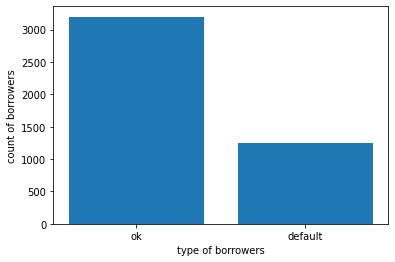

In [577]:
status_type = ['ok', 'default']
count = [3200, 1254]

plt.bar(status_type, count)
plt.xlabel('type of borrowers')
plt.ylabel('count of borrowers')

###Create the target variable

In [578]:
df['default'] = (df.status == 'default').astype(int)    # creates a default column with the values of the status column as intergers (0 for ok and 1 for default)
del df['status']

In [579]:
df.head()

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
0,9,rent,60,30,married,no,freelance,73,129,0,0,800,846,0
1,17,rent,60,58,widow,no,fixed,48,131,0,0,1000,1658,0
2,10,owner,36,46,married,yes,freelance,90,200,3000,0,2000,2985,1
3,0,rent,60,24,single,no,fixed,63,182,2500,0,900,1325,0
4,0,rent,36,26,single,no,fixed,46,107,0,0,310,910,0


###Let's recollect our catergorical and numerical variables

- What are the categorical variables? What are the numerical variables?

In [580]:
# categorical data
print('Categorical variables:',  '\n')
print(cat)

print('\n')

# numerical data
print('Numerical variables:',  '\n')
print(num)

Categorical variables: 

Index(['status', 'home', 'marital', 'records', 'job'], dtype='object')


Numerical variables: 

Index(['seniority', 'time', 'age', 'expenses', 'income', 'assets', 'debt',
       'amount', 'price'],
      dtype='object')


###Setting up the Validation Framework
* Creating training, validation and test data
* Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use train_test_split funciton in sklearn with random_state=1



* The split is done in two stages: first split is 80%:20% - the 20% being the test data - and the second is 75%:25% of the first stage 80% where the 25% is the validation data.

In [581]:
from sklearn.model_selection import train_test_split 

In [582]:
#Splitting the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1) 

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) 

#Checking the length of the three sub data

len(df_train), len(df_val), len(df_test) 

(2672, 891, 891)

In [583]:
df_train

,seniority,home,time,age,marital,records,job,expenses,income,assets,debt,amount,price,default
1877,12,private,24,28,married,no,fixed,45,102,0,0,700,1229,1
1803,4,other,60,28,married,no,fixed,60,143,0,0,1150,1630,0
3400,0,owner,60,27,married,no,fixed,35,295,6000,0,1950,2208,0
3529,6,owner,48,28,married,no,fixed,45,114,3500,0,650,1255,0
1721,12,owner,36,42,married,no,freelance,60,0,15000,0,1000,1500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2436,0,rent,48,54,married,no,freelance,135,0,0,0,2000,2476,1
1956,6,rent,12,33,married,no,fixed,85,250,0,0,500,1500,0
91,9,parents,60,32,single,yes,fixed,35,105,0,0,1490,1490,1
3602,0,parents,60,21,single,no,others,35,149,3000,0,1400,1829,0


## Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score and compute AUC with the "default" variable
* Use the training dataset for that




> - If your AUC is < 0.5, invert this variable by putting "-" in front  (e.g. `-df_train['expenses']`)

AUC can go below 0.5 if the variable is negatively correlated with the target varialble. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

In [584]:
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve

In [585]:
for var in num:
  auc_score = roc_auc_score(df_train['default'], df_train[var])
  if auc_score < 0.5:
    auc_score = roc_auc_score(df_train['default'], -df_train[var])
  print(var, auc_score.round(2))

seniority 0.71
time 0.56
age 0.57
expenses 0.5
income 0.68
assets 0.65
debt 0.5
amount 0.59
price 0.5


Which numerical variable (among the following 4) has the highest AUC?

- seniority
- time
- income
- debt

**Answer 1:
```Seniority``` has the highest AUC.**

## Training the model

From now on, let's use these columns only:
- 
```
['seniority', 'income', 'assets', 'records', 'job', 'home']
```

- Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:
- 
```
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

In [586]:
from sklearn.linear_model import LogisticRegression

from sklearn.feature_extraction import DictVectorizer

In [587]:
use_cols = ['seniority', 'income', 'assets', 'records', 'job', 'home']

###Prepare data with the selected columns

In [588]:

#Splitting the data
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1) 

df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.default.values
y_val = df_val.default.values
y_test = df_test.default.values

del df_train['default']
del df_val['default']
del df_test['default']

df_train = df_train[use_cols]
df_val = df_val[use_cols]
df_test = df_test[use_cols]




 


  

In [589]:
len(df_train)

2672

In [590]:
df_train

,seniority,income,assets,records,job,home
0,12,102,0,no,fixed,private
1,4,143,0,no,fixed,other
2,0,295,6000,no,fixed,owner
3,6,114,3500,no,fixed,owner
4,12,0,15000,no,freelance,owner
...,...,...,...,...,...,...
2667,0,0,0,no,freelance,rent
2668,6,250,0,no,fixed,rent
2669,9,105,0,yes,fixed,parents
2670,0,149,3000,no,others,parents


###Applying One-Hot encoding and training our model

In [591]:
#Apply one-hot-encoding using DictVectorizer

dicts_train = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dicts_train)
  
#Train model

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

###Prepare data for validation and test

In [592]:
#Apply one-hot-encoding using DictVectorizer

dv = DictVectorizer(sparse=False)

dicts_val = df_val.to_dict(orient='records')


X_val = dv.fit_transform(dicts_val)

dicts_test = df_test.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_test = dv.fit_transform(dicts_test)



###Predict the propbabilities of default

In [593]:
y_pred = model.predict_proba(X_val)[:, 1]

In [594]:
y_pred[:5]

array([0.19686431, 0.11756687, 0.26981906, 0.12327234, 0.04141657])

####Accuracy

In [595]:
default_decision = (y_pred >= 0.5)
(y_val == default_decision).mean().round(2)

0.78

In [596]:
accuracy_score(y_val, y_pred >= 0.5).round(2)

0.78

## Question 2

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.512
- 0.612
- 0.712
- 0.812

####AUC of the model on Validation set

In [597]:
roc_auc_score(y_val, y_pred).round(3)

0.812

**Answer 2: The AUC of the model on Validation set is 0.812**

## Question 3

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

**Note**:
* *Precision (p) = tp / (tp + fp)*
> This is the proportion of predicted positive (defaults) who are actual positives (defaults). This is the **predictive value of positive** prediction and is also known as post test probability given a predicted positive (i.e., default)



* *Recall = tP / (tp + fn)*
> This is the proportion of actual positives (defaults) in our data who our model predicted correctly as positives (defaults). Is also called **sensitivity**, **probability of detection** and the **power** of the model.

In [598]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

- Let's convert the list of tupels to dataframe for ease of manipulation.

In [599]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

# compute the TPR, FPR, Precision and Recall scores and add them as columns
df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.tn)
df_scores['precision'] = df_scores.tp / (df_scores.tp + df_scores.fp)
df_scores['recall'] = df_scores.tp / (df_scores.tp + df_scores.fn)

In [600]:
df_scores[::1]  #display rows in multiples of ten

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall
0,0.00,246,645,0,0,1.00000,1.000000,0.276094,1.00000
1,0.01,246,635,0,10,1.00000,0.984496,0.279228,1.00000
2,0.02,244,613,2,32,0.99187,0.950388,0.284714,0.99187
3,0.03,242,593,4,52,0.98374,0.919380,0.289820,0.98374
4,0.04,242,563,4,82,0.98374,0.872868,0.300621,0.98374
...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,246,645,0.00000,0.000000,NaN,0.00000
97,0.97,0,0,246,645,0.00000,0.000000,NaN,0.00000
98,0.98,0,0,246,645,0.00000,0.000000,NaN,0.00000
99,0.99,0,0,246,645,0.00000,0.000000,NaN,0.00000


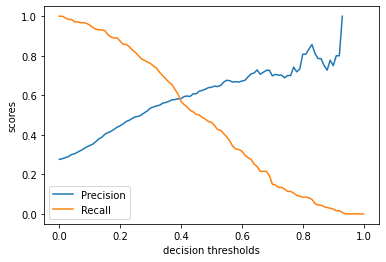

In [601]:
plt.plot(df_scores.threshold, df_scores['precision'], label='Precision')
plt.plot(df_scores.threshold, df_scores['recall'], label='Recall')
plt.xlabel('decision thresholds')
plt.ylabel('scores')
plt.legend()

At which threshold precision and recall curves intersect?

* 0.2
* 0.4
* 0.6
* 0.8

**Answer 3: Precision and Recall curves intersect at threshold 0.4**

## Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both.

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [602]:
df_scores['f1_score'] = 2 * (df_scores.precision * df_scores.recall) / (df_scores.precision + df_scores.recall)

df_scores

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,f1_score
0,0.00,246,645,0,0,1.00000,1.000000,0.276094,1.00000,0.432718
1,0.01,246,635,0,10,1.00000,0.984496,0.279228,1.00000,0.436557
2,0.02,244,613,2,32,0.99187,0.950388,0.284714,0.99187,0.442430
3,0.03,242,593,4,52,0.98374,0.919380,0.289820,0.98374,0.447734
4,0.04,242,563,4,82,0.98374,0.872868,0.300621,0.98374,0.460514
...,...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,246,645,0.00000,0.000000,NaN,0.00000,NaN
97,0.97,0,0,246,645,0.00000,0.000000,NaN,0.00000,NaN
98,0.98,0,0,246,645,0.00000,0.000000,NaN,0.00000,NaN
99,0.99,0,0,246,645,0.00000,0.000000,NaN,0.00000,NaN


At which threshold F1 is maximal?

- 0.1
- 0.3
- 0.5
- 0.7

In [603]:
df_scores.sort_values('f1_score', ascending=False)

,threshold,tp,fp,fn,tn,tpr,fpr,precision,recall,f1_score
30,0.30,187,162,59,483,0.760163,0.251163,0.535817,0.760163,0.628571
31,0.31,184,156,62,489,0.747967,0.241860,0.541176,0.747967,0.627986
32,0.32,181,150,65,495,0.735772,0.232558,0.546828,0.735772,0.627383
34,0.34,172,135,74,510,0.699187,0.209302,0.560261,0.699187,0.622061
33,0.33,176,144,70,501,0.715447,0.223256,0.550000,0.715447,0.621908
...,...,...,...,...,...,...,...,...,...,...
96,0.96,0,0,246,645,0.000000,0.000000,NaN,0.000000,NaN
97,0.97,0,0,246,645,0.000000,0.000000,NaN,0.000000,NaN
98,0.98,0,0,246,645,0.000000,0.000000,NaN,0.000000,NaN
99,0.99,0,0,246,645,0.000000,0.000000,NaN,0.000000,NaN


**Answer 4: The maximal F1 Score occurs at a threshold of 0.3**

## Question 5


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation


K-fold cross validation means we split the entire dataset into K equal parts or folds. Then, for each fold, we take it as the validation dataset and use the remaining K–1 folds as the training data. After training the model we evaluate it on the validation fold, and at the end we get K metric values.

We then compute the mean and standard deviations of the K validation AUC scores to see the average performance and how stable the model is.

To do this, we first define a train function to prepare our data and train the model. Then we define another function to predict the probabilities.

In [604]:
len(df_full_train), len(df_val)

(3563, 891)

In [605]:
categorical = list(df_train.dtypes[df_train.dtypes == 'object'].index)
numerical = list(df_train.dtypes[df_train.dtypes != 'object'].index)

In [606]:
def train(df_train, y_train, C=1.0):
  
  dicts = df_train[categorical + numerical].to_dict(orient='records')

  dv = DictVectorizer(sparse=False)
  X_train = dv.fit_transform(dicts)

  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
  model.fit(X_train, y_train)
    
  return dv, model

In [607]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

- We will implement the K-fold cross validation using KFold function of the model_selection package in Scikit_learn

In [608]:
from sklearn.model_selection import KFold

from tqdm.auto import tqdm

In [609]:
n_splits = 5

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]
    
    y_train = df_train.default.values
    y_val = df_val.default.values
    
    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)
    
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [610]:
round(np.mean(scores),3), round(np.std(scores),3)

(0.812, 0.014)

In [611]:
print('Mean AUC is {0}.'.format(np.mean(scores).round(3)))
print('Standard deviation of AUCs is {0}.'.format(np.std(scores).round(3)))

Mean AUC is 0.812.
Standard deviation of AUCs is 0.014.


How large is standard devidation of the scores across different folds?

- 0.001
- 0.014
- 0.09
- 0.14

**Answer 5: The standard devidation of the scores across different folds is 0.014.**

## Question 6

Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize `KFold` with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

In [612]:
n_splits = 5

for C in tqdm([0.01, 0.1, 1, 10]):
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.default.values
        y_val = df_val.default.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.808 +- 0.012
C=0.1 0.813 +- 0.014
C=1 0.812 +- 0.014
C=10 0.814 +- 0.015


Which C leads to the best mean score?

- 0.01
- 0.1
- 1
- 10



**Answer 6. Regularization parameter C = 10 produces the highest mean AUC score of 0.814.**

We note that this mean AUC is close to the 0.812 we found earlier for our model on the validation set.